In [11]:
import pandas as pd

# === Load entropy files ===
lusc_entropy = pd.read_csv("/content/sample_data/LUSC_9Pathway_Entropy.csv")
coadread_entropy = pd.read_csv("/content/sample_data/COADREAD_9Pathway_Entropy.csv")

# === Standardize TCGA IDs ===
lusc_entropy["TCGA_ID"] = lusc_entropy["patient_id"].str[:12]
coadread_entropy["TCGA_ID"] = coadread_entropy["patient_id"].str[:12]

# === Load clinical file ===
clinical_df = pd.read_csv("/content/sample_data/final_dataset_with_clinical (1).csv")
clinical_df["TCGA_ID"] = clinical_df["bcr_patient_barcode"].str[:12]

# === Find common patients ===
common_lusc = set(lusc_entropy["TCGA_ID"]) & set(clinical_df["TCGA_ID"])
common_coadread = set(coadread_entropy["TCGA_ID"]) & set(clinical_df["TCGA_ID"])

# === Output result ===
print(f"🧬 Common patients in LUSC entropy + clinical: {len(common_lusc)}")
print(f"🧬 Common patients in COADREAD entropy + clinical: {len(common_coadread)}")

# Optional: Save lists of common patients
pd.Series(list(common_lusc)).to_csv("common_lusc_patients.csv", index=False, header=["TCGA_ID"])
pd.Series(list(common_coadread)).to_csv("common_coadread_patients.csv", index=False, header=["TCGA_ID"])


🧬 Common patients in LUSC entropy + clinical: 419
🧬 Common patients in COADREAD entropy + clinical: 357


/tmp/ipython-input-11-1196706357.py:12: DtypeWarning: Columns (150) have mixed types. Specify dtype option on import or set low_memory=False.
  clinical_df = pd.read_csv("/content/sample_data/final_dataset_with_clinical (1).csv")


In [12]:
import pandas as pd

# === Load and standardize clinical data ===
clinical_df = pd.read_csv("/content/sample_data/final_dataset_with_clinical (1).csv")
clinical_df["TCGA_ID"] = clinical_df["bcr_patient_barcode"].str[:12]
clinical_df = clinical_df.drop_duplicates(subset="TCGA_ID")

# === Load and process entropy datasets ===
def load_entropy(file_path, cancer_type_label):
    df = pd.read_csv(file_path)
    df["TCGA_ID"] = df["patient_id"].str[:12]
    df = df.drop_duplicates(subset="TCGA_ID")
    df["cancer_type"] = cancer_type_label
    return df.drop(columns=["patient_id"])

lusc_entropy = load_entropy("/content/sample_data/LUSC_9Pathway_Entropy.csv", "LUSC")
coadread_entropy = load_entropy("/content/sample_data/COADREAD_9Pathway_Entropy.csv", "COADREAD")

# === Concatenate both entropy datasets ===
combined_entropy = pd.concat([lusc_entropy, coadread_entropy], ignore_index=True)

# === Merge with clinical data ===
unified_df = pd.merge(combined_entropy, clinical_df, on="TCGA_ID", how="inner")

# === Save the unified dataset ===
unified_df.to_csv("unified_entropy_clinical.csv", index=False)
print(f"[✓] Unified dataset created with shape: {unified_df.shape}")


[✓] Unified dataset created with shape: (776, 180)


/tmp/ipython-input-12-3184169847.py:4: DtypeWarning: Columns (150) have mixed types. Specify dtype option on import or set low_memory=False.
  clinical_df = pd.read_csv("/content/sample_data/final_dataset_with_clinical (1).csv")


In [13]:
import pandas as pd

# Load the unified dataset
unified_df = pd.read_csv("unified_entropy_clinical.csv")

# Check for duplicate TCGA IDs
duplicates = unified_df[unified_df.duplicated(subset="TCGA_ID", keep=False)]

# Report and optionally print them
num_duplicates = duplicates["TCGA_ID"].nunique()
print(f"[!] Number of duplicated TCGA_IDs: {num_duplicates}")

if num_duplicates > 0:
    print("🔁 Duplicate entries:")
    print(duplicates.sort_values("TCGA_ID"))


[!] Number of duplicated TCGA_IDs: 0


In [15]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 7.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=e09fd99f2fb4d7ae489a044e050fe3a0e12f2386fccf6d0e60367eab3b960a32
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [39]:
from lifelines import CoxPHFitter

def run_cox_by_cancer_type(df, cancer_type):
    if cancer_type == "LUSC":
        entropy_cols = [
            "CellCycle_KRAS_RB", "CellCycle_MTOR_RB", "CellCycle_TGFBR2_RB",
            "Metab_ERK_AMPK", "Metab_VHL_HIF", "Metab_BRAF_NFE2L2",
            "RTK_EGFR_AKT", "RTK_MET_AKT", "RTK_ALK_AKT"
        ]
    elif cancer_type == "COADREAD":
        entropy_cols = [
            "COADREAD_CellCycle_APC_RB", "COADREAD_CellCycle_MTOR_RB", "COADREAD_CellCycle_TGFBR2_RB",
            "COADREAD_Metabolism_ERK_AMPK", "COADREAD_Metabolism_VHL_HIF", "COADREAD_Metabolism_ERK_HIF",
            "COADREAD_Proliferation_EGFR_AKT", "COADREAD_Proliferation_MET_AKT", "COADREAD_Proliferation_ALK_AKT"
        ]
    else:
        print(f"❌ Unknown cancer type: {cancer_type}")
        return

    df_cancer = df[df["cancer_type_x"] == cancer_type].copy()
    df_cancer = df_cancer.dropna(subset=["OS", "OS.time"])
    df_cancer = df_cancer[df_cancer["OS.time"] > 0].copy()

    cox_df = df_cancer[entropy_cols + ["OS", "OS.time"]].dropna()

    if cox_df.shape[0] < 5:
        print(f"⚠️ Not enough valid patients for {cancer_type} (only {cox_df.shape[0]} rows). Skipping CoxPH.")
        return

    print(f"\n📊 CoxPH Summary for {cancer_type}:")
    cph = CoxPHFitter()
    cph.fit(cox_df, duration_col="OS.time", event_col="OS")
    cph.print_summary()


In [40]:
run_cox_by_cancer_type(unified_df, "LUSC")
run_cox_by_cancer_type(unified_df, "COADREAD")



📊 CoxPH Summary for LUSC:


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['Metab_ERK_AMPK', 'Metab_BRAF_NFE2L2'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


<lifelines.CoxPHFitter: fitted with 418 total observations, 265 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 418
number of events observed = 153
   partial log-likelihood = -793.29
         time fit was run = 2025-07-19 03:45:50 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
CellCycle_KRAS_RB    -3.21      0.04      2.12           -7.36            0.93                0.00                2.54
CellCycle_MTOR_RB     7.60   2001.73      3.61            0.52           14.68                1.68            2.38e+06
CellCycle_TGFBR2_RB  -8.07      0.00      3.75          -15.41           -0.72                0.00                0.49
Metab_ERK_AMPK        2.31     10.10     13.32          -23.80           28.43                0.00            2.22e+12
Metab_VHL_HIF         0.80      2.22      2.26           -3.64            5.24                0.03              187.83
Metab_BRAF_NFE2L2   -33.61      0.00     13.29          -59.66           -7.55                0.00                0.00
RTK_EGFR_AKT         -0.19      0.83      4.65           -9.31            8.93                0.00             7522.12
RTK_MET_AKT          -0.24      0.79      5.61          -11.24           10.75                0.00            46821.15
RTK_ALK_AKT           0.46      1.59      0.25           -0.03            0.95                0.97                2.60

                     cmp to     z    p  -log2(p)
covariate                                       
CellCycle_KRAS_RB      0.00 -1.52 0.13      2.96
CellCycle_MTOR_RB      0.00  2.10 0.04      4.82
CellCycle_TGFBR2_RB    0.00 -2.15 0.03      4.99
Metab_ERK_AMPK         0.00  0.17 0.86      0.21
Metab_VHL_HIF          0.00  0.35 0.72      0.47
Metab_BRAF_NFE2L2      0.00 -2.53 0.01      6.45
RTK_EGFR_AKT           0.00 -0.04 0.97      0.05
RTK_MET_AKT            0.00 -0.04 0.97      0.05
RTK_ALK_AKT            0.00  1.83 0.07      3.91
---
Concordance = 0.58
Partial AIC = 1604.59
log-likelihood ratio test = 13.40 on 9 df
-log2(p) of ll-ratio test = 2.78


📊 CoxPH Summary for COADREAD:


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['COADREAD_Metabolism_ERK_AMPK'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


<lifelines.CoxPHFitter: fitted with 353 total observations, 289 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 353
number of events observed = 64
   partial log-likelihood = -317.08
         time fit was run = 2025-07-19 03:45:50 UTC

---
                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                         
COADREAD_CellCycle_APC_RB        40.29  3.14e+17     14.80           11.28           69.30            78941.11            1.25e+30
COADREAD_CellCycle_MTOR_RB      -17.32      0.00      6.39          -29.84           -4.80                0.00                0.01
COADREAD_CellCycle_TGFBR2_RB    -11.10      0.00      7.63          -26.06            3.85                0.00               47.22
COADREAD_Metabolism_ERK_AMPK     13.78  9.66e+05     36.65          -58.05           85.61                0.00            1.51e+37
COADREAD_Metabolism_VHL_HIF      12.67  3.19e+05      9.12           -5.20           30.54                0.01            1.83e+13
COADREAD_Metabolism_ERK_HIF      -4.86      0.01      7.78          -20.11           10.39                0.00            32620.53
COADREAD_Proliferation_EGFR_AKT  -1.95      0.14      9.95          -21.46           17.56                0.00            4.22e+07
COADREAD_Proliferation_MET_AKT  -10.69      0.00     13.19          -36.54           15.16                0.00            3.83e+06
COADREAD_Proliferation_ALK_AKT   -0.27      0.76      0.30           -0.86            0.31                0.42                1.37

                                 cmp to     z    p  -log2(p)
covariate                                                   
COADREAD_CellCycle_APC_RB          0.00  2.72 0.01      7.27
COADREAD_CellCycle_MTOR_RB         0.00 -2.71 0.01      7.22
COADREAD_CellCycle_TGFBR2_RB       0.00 -1.45 0.15      2.78
COADREAD_Metabolism_ERK_AMPK       0.00  0.38 0.71      0.50
COADREAD_Metabolism_VHL_HIF        0.00  1.39 0.16      2.60
COADREAD_Metabolism_ERK_HIF        0.00 -0.62 0.53      0.91
COADREAD_Proliferation_EGFR_AKT    0.00 -0.20 0.84      0.24
COADREAD_Proliferation_MET_AKT     0.00 -0.81 0.42      1.26
COADREAD_Proliferation_ALK_AKT     0.00 -0.92 0.36      1.48
---
Concordance = 0.64
Partial AIC = 652.16
log-likelihood ratio test = 16.35 on 9 df
-log2(p) of ll-ratio test = 4.06

In [43]:
print("Total patients:", unified_df.shape[0])
print("Missing OS:", unified_df["OS"].isna().sum())
print("Missing OS.time:", unified_df["OS.time"].isna().sum())
print("Zero OS.time:", (unified_df["OS.time"] == 0).sum())
print("Valid LUSC:", unified_df[(unified_df["cancer_type_x"] == "LUSC") &
                                (unified_df["OS"].notna()) &
                                (unified_df["OS.time"].notna()) &
                                (unified_df["OS.time"] > 0)].shape[0])

print("Valid COADREAD:", unified_df[(unified_df["cancer_type_x"] == "COADREAD") &
                                    (unified_df["OS"].notna()) &
                                    (unified_df["OS.time"].notna()) &
                                    (unified_df["OS.time"] > 0)].shape[0])


Total patients: 776
Missing OS: 0
Missing OS.time: 0
Zero OS.time: 5
Valid LUSC: 418
Valid COADREAD: 353


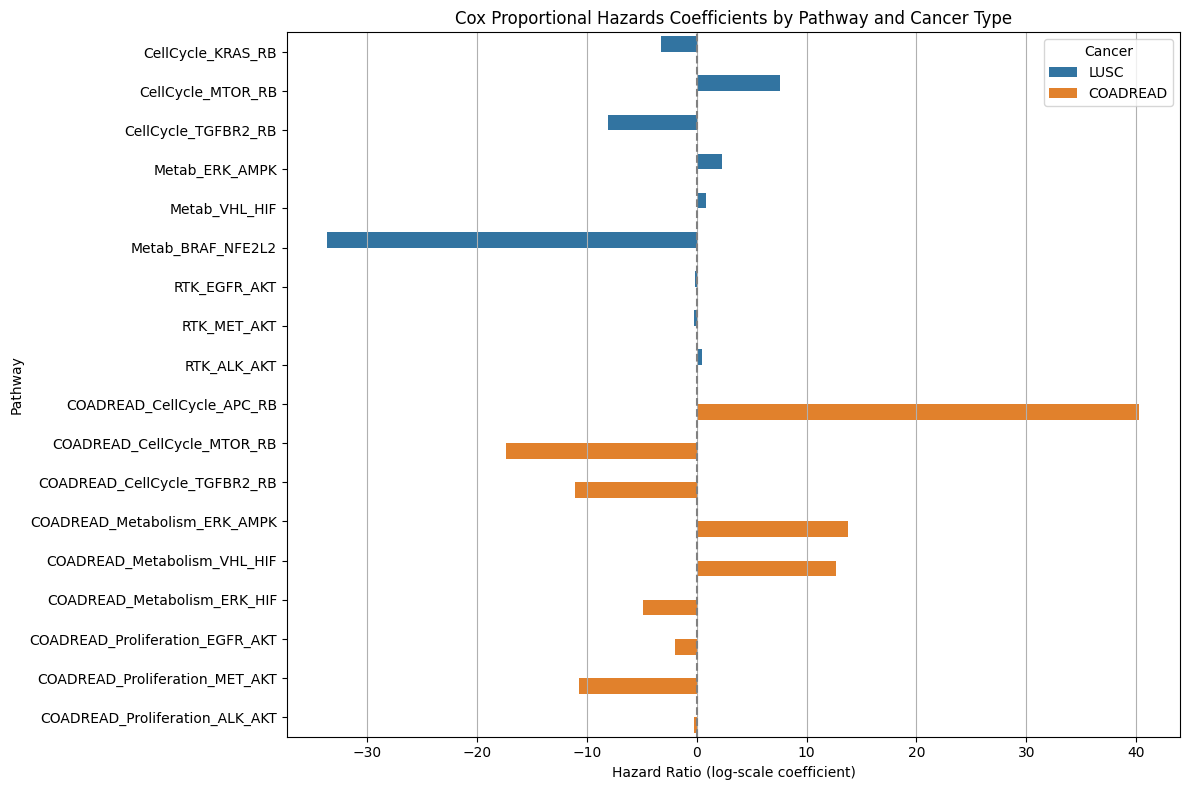

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

# Create CoxPH result tables for LUSC and COADREAD
lusc_data = """
Pathway,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,p
CellCycle_KRAS_RB,-3.21,0.04,2.12,-7.36,0.93,0.13
CellCycle_MTOR_RB,7.60,2001.73,3.61,0.52,14.68,0.04
CellCycle_TGFBR2_RB,-8.07,0.00,3.75,-15.41,-0.72,0.03
Metab_ERK_AMPK,2.31,10.10,13.32,-23.80,28.43,0.86
Metab_VHL_HIF,0.80,2.22,2.26,-3.64,5.24,0.72
Metab_BRAF_NFE2L2,-33.61,0.00,13.29,-59.66,-7.55,0.01
RTK_EGFR_AKT,-0.19,0.83,4.65,-9.31,8.93,0.97
RTK_MET_AKT,-0.24,0.79,5.61,-11.24,10.75,0.97
RTK_ALK_AKT,0.46,1.59,0.25,-0.03,0.95,0.07
"""

coadread_data = """
Pathway,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,p
COADREAD_CellCycle_APC_RB,40.29,3.14e+17,14.80,11.28,69.30,0.01
COADREAD_CellCycle_MTOR_RB,-17.32,0.00,6.39,-29.84,-4.80,0.01
COADREAD_CellCycle_TGFBR2_RB,-11.10,0.00,7.63,-26.06,3.85,0.15
COADREAD_Metabolism_ERK_AMPK,13.78,9.66e+05,36.65,-58.05,85.61,0.71
COADREAD_Metabolism_VHL_HIF,12.67,3.19e+05,9.12,-5.20,30.54,0.16
COADREAD_Metabolism_ERK_HIF,-4.86,0.01,7.78,-20.11,10.39,0.53
COADREAD_Proliferation_EGFR_AKT,-1.95,0.14,9.95,-21.46,17.56,0.84
COADREAD_Proliferation_MET_AKT,-10.69,0.00,13.19,-36.54,15.16,0.42
COADREAD_Proliferation_ALK_AKT,-0.27,0.76,0.30,-0.86,0.31,0.36
"""

# Load data into DataFrames
lusc_df = pd.read_csv(StringIO(lusc_data))
lusc_df["Cancer"] = "LUSC"

coadread_df = pd.read_csv(StringIO(coadread_data))
coadread_df["Cancer"] = "COADREAD"

# Combine and plot
combined_df = pd.concat([lusc_df, coadread_df], ignore_index=True)

plt.figure(figsize=(12, 8))
sns.barplot(data=combined_df, x="coef", y="Pathway", hue="Cancer", dodge=True)
plt.axvline(0, color='grey', linestyle='--')
plt.title("Cox Proportional Hazards Coefficients by Pathway and Cancer Type")
plt.xlabel("Hazard Ratio (log-scale coefficient)")
plt.ylabel("Pathway")
plt.tight_layout()
plt.grid(axis='x')
plt.show()


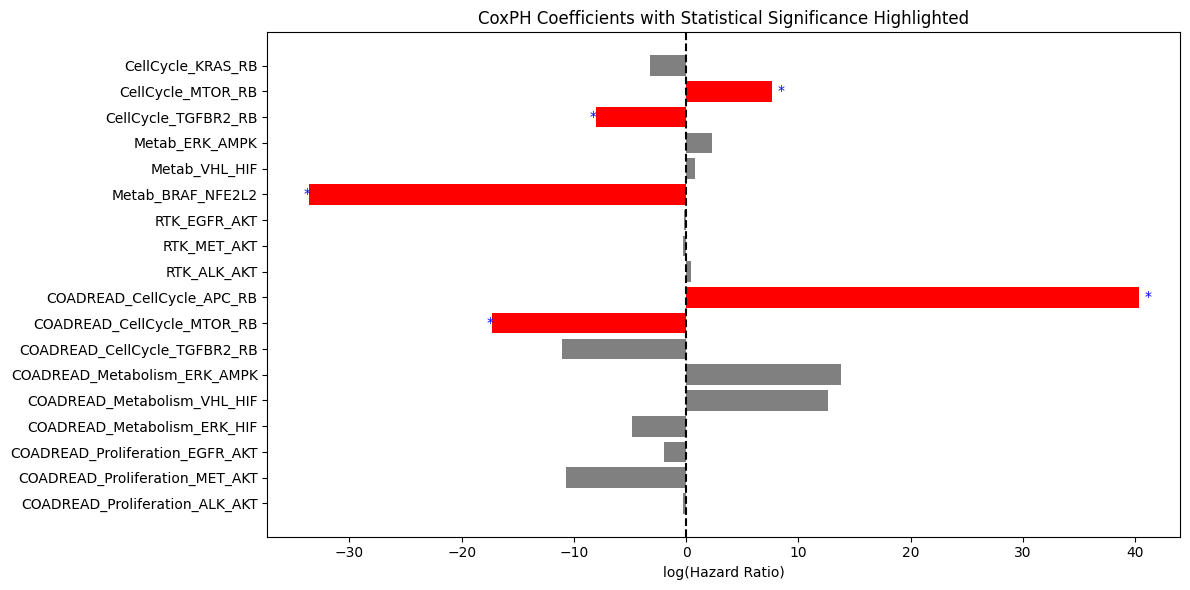

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

# LUSC results
lusc_data = {
    'Pathway': [
        'CellCycle_KRAS_RB', 'CellCycle_MTOR_RB', 'CellCycle_TGFBR2_RB',
        'Metab_ERK_AMPK', 'Metab_VHL_HIF', 'Metab_BRAF_NFE2L2',
        'RTK_EGFR_AKT', 'RTK_MET_AKT', 'RTK_ALK_AKT'
    ],
    'coef': [-3.21, 7.60, -8.07, 2.31, 0.80, -33.61, -0.19, -0.24, 0.46],
    'p': [0.13, 0.04, 0.03, 0.86, 0.72, 0.01, 0.97, 0.97, 0.07],
    'Cancer': ['LUSC'] * 9
}

# COADREAD results
coad_data = {
    'Pathway': [
        'COADREAD_CellCycle_APC_RB', 'COADREAD_CellCycle_MTOR_RB', 'COADREAD_CellCycle_TGFBR2_RB',
        'COADREAD_Metabolism_ERK_AMPK', 'COADREAD_Metabolism_VHL_HIF', 'COADREAD_Metabolism_ERK_HIF',
        'COADREAD_Proliferation_EGFR_AKT', 'COADREAD_Proliferation_MET_AKT', 'COADREAD_Proliferation_ALK_AKT'
    ],
    'coef': [40.29, -17.32, -11.10, 13.78, 12.67, -4.86, -1.95, -10.69, -0.27],
    'p': [0.01, 0.01, 0.15, 0.71, 0.16, 0.53, 0.84, 0.42, 0.36],
    'Cancer': ['COADREAD'] * 9
}

# Create DataFrame
df_lusc = pd.DataFrame(lusc_data)
df_coad = pd.DataFrame(coad_data)
df_all = pd.concat([df_lusc, df_coad])

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
colors = df_all['p'].apply(lambda p: 'red' if p < 0.05 else 'gray')

bars = ax.barh(df_all['Pathway'], df_all['coef'], color=colors)
ax.axvline(0, linestyle='--', color='black')
ax.set_title('CoxPH Coefficients with Statistical Significance Highlighted')
ax.set_xlabel('log(Hazard Ratio)')
ax.invert_yaxis()

# Add significance stars
for i, (coef, p) in enumerate(zip(df_all['coef'], df_all['p'])):
    label = '*' if p < 0.05 else ''
    ax.text(coef + 0.5 if coef > 0 else coef - 0.5, i, label, color='blue', va='center')

plt.tight_layout()
plt.show()
